# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [427]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [428]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [429]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [430]:
X_train, Y_train = generate_dataset(20000) # Training dataset increased to 20000
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [431]:
i =  np.random.randint(10000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

1299
infix :  ( ( ( e - e ) + d ) - ( ( a - d ) / c ) )
posfix notation:  e e - d + a d - c / -
teacher forcing :  SOS e e - d + a d - c / -


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




In [432]:
# ------------------------ Sequence-to-Sequence Model with Attention ------------------------
"""
This script defines a sequence-to-sequence (seq2seq) architecture with Luong style dotproduct attention,
uses for translation or mathematical expression transformation. 

This model includes:
- An encoder: processes input sequences and generates context aware hidden states.
- A decoder: generates output sequences, one token at a time, using context from the encoder.
- Attention: allows the decoder to focus on relevant parts of the input sequence.
"""

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# ------------------------ Encoder Definition ------------------------
# Create a space where the model will receive the input sentence which is going to be encoded
encoder_inputs = Input(shape=(MAX_LEN,), name='encoder_inputs')

# Embedding layer to transform token indices into dense vectors
encoder_embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,     # size of the vocabulary
    output_dim=64,            # embedding vector dimension
    name='encoder_embedding'
)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

# LSTM layer processes embedded input sequence and outputs hidden states
encoder_lstm = LSTM(
    units=128,                # dimensionality of the LSTM output
    return_sequences=True,   # return full sequence (needed for attention)
    return_state=True,       # also return the final hidden and cell states
    name='encoder_lstm'
)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Save the final encoder states to initialize decoder
encoder_states = [state_h, state_c]

# ------------------------ Decoder Definition ------------------------
# Define an input placeholder for decoder (target sequence)
decoder_inputs = Input(shape=(MAX_LEN,), name='decoder_inputs')

# Embedding layer for decoder input
decoder_embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=64,
    name='decoder_embedding'
)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# LSTM for decoding with initial states from the encoder
decoder_lstm = LSTM(
    units=128,
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)
decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding,
    initial_state=encoder_states
)

# -------------------- Attention Mechanism (Luong dot-product attention) ---------------------
# Helps the model to focus on the most relevant words in the input when generating each word in the output
attention_layer = Attention(name='attention')
context_vector = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate context vector with decoder output
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')(
    [decoder_outputs, context_vector]
)

# ------------------------ Output Layer ------------------------
# Dense layer with softmax activation to predict next token
decoder_dense = Dense(
    units=VOCAB_SIZE,
    activation='softmax',
    name='decoder_dense'
)
decoder_outputs = decoder_dense(decoder_combined_context)

# ------------------------ Model Compilation ------------------------
# Define the complete training model
training_model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

# Compile the model for training
training_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture summary
print(training_model.summary())


Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 30, 64)    │        960 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 30, 64)    │        960 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 30, 128), │     98,816 │ encoder_embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 30, 128), │     98,816 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 128)   │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 30, 256)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 30, 15)    │      3,855 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,407 (794.56 KB)

 Trainable params: 203,407 (794.56 KB)

 Non-trainable params: 0 (0.00 B)

None


In [433]:
# ------------------------ Inference Models for Sequence Generation ------------------------
"""
This section defines the inference models used for autoregressive decoding after training.

Two separate models are created:

1. Encoder Inference Model:
   Encodes the input sequence and returns the encoder outputs along with the final LSTM states (h, c).

2. Decoder Inference Model:
   Takes one token at a time, along with previous decoder states and encoder outputs, and returns the next token's
   probability distribution along with the updated decoder states.

These two models enable step by step decoding during inference.
"""

# ------------------------ Encoder Inference Model ------------------------

# Constructs the encoder model to output encoder sequence and final LSTM states
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h, state_c]
)

# ------------------------ Decoder Inference Model ------------------------

# Input for a single decoder token (used one timestep at a time)
decoder_single_input = Input(shape=(1,), name='decoder_single_input')

# Inputs for the previous decoder hidden and cell states
decoder_state_input_h = Input(shape=(128,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(128,), name='decoder_state_input_c')

# Input for encoder outputs (used to compute attention)
encoder_outputs_input = Input(shape=(MAX_LEN, 128), name='encoder_outputs_input')

# Embedding the single decoder input token
decoder_single_embedded = decoder_embedding_layer(decoder_single_input)

# LSTM processes the embedded token with the previous hidden and cell states
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_single_embedded,
    initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Apply attention: aligns decoder output with encoder outputs to produce a context vector
context_vector_inf = attention_layer([decoder_outputs_inf, encoder_outputs_input])

# Concatenate decoder output with the context vector from attention
decoder_combined_context_inf = Concatenate(axis=-1)(
    [decoder_outputs_inf, context_vector_inf]
)

# Dense layer generates the probability distribution over the vocabulary
decoder_pred_inf = decoder_dense(decoder_combined_context_inf)

# Assemble the decoder inference model
decoder_model = Model(
    inputs=[
        decoder_single_input,
        decoder_state_input_h,
        decoder_state_input_c,
        encoder_outputs_input
    ],
    outputs=[
        decoder_pred_inf,
        state_h_inf,
        state_c_inf
    ]
)


In [434]:
# ------------------------ Autoregressive Decoding Function ------------------------

def autoregressive_decode(
    encoder_model,
    decoder_model,
    encoder_input,
    max_len=MAX_LEN,
    sos_id=SOS_ID,
    eos_id=EOS_ID,
    pad_id=PAD_ID
):
    """
    Perform autoregressive decoding using trained encoder and decoder models.

    This function generates an output sequence token by token using the encoder decoder
    architecture with attention. It starts from the start-of-sequence (SOS) token and 
    continues predicting one token at a time until the end-of-sequence (EOS) token is 
    predicted or the maximum length is reached.

    Args:
        encoder_model (keras.Model): The trained encoder model for inference.
        decoder_model (keras.Model): The trained decoder model for inference.
        encoder_input (np.ndarray): Input sequence to be encoded (1D array of token IDs).
        max_len (int): Maximum length of the decoded sequence.
        sos_id (int): Token ID representing the start of sequence.
        eos_id (int): Token ID representing the end of sequence.
        pad_id (int): Token ID used for padding.

    Returns:
        List[int]: A list of token IDs representing the decoded output sequence, 
                   including the SOS and EOS tokens.
    """

    # Expand input to match batch dimension expected by encoder (batch_size=1)
    encoder_input = np.expand_dims(encoder_input, axis=0)

    # Run encoder to obtain the encoder outputs and final LSTM states
    encoder_outputs, state_h, state_c = encoder_model.predict(encoder_input)

    # Initialize decoded sequence with the SOS token
    decoded_seq = [sos_id]
    decoder_state_h = state_h
    decoder_state_c = state_c

    # Generate output tokens one by one up to max_len
    for _ in range(max_len):
        # Prepare the input token for the decoder (last predicted token)
        decoder_input_token = np.array([[decoded_seq[-1]]])

        # Predict the next token using the decoder model
        preds, decoder_state_h, decoder_state_c = decoder_model.predict(
            [decoder_input_token, decoder_state_h, decoder_state_c, encoder_outputs],
            verbose=0
        )

        # Select the token with the highest probability
        next_token_id = int(np.argmax(preds[0, 0]))

        # Append predicted token to output sequence
        decoded_seq.append(next_token_id)

        # Stop decoding if EOS token is predicted
        if next_token_id == eos_id:
            break

    return decoded_seq


Epoch 1/8
313/313 - 17s - 53ms/step - accuracy: 0.8399 - loss: 0.4351 - val_accuracy: 0.9053 - val_loss: 0.2421
Epoch 2/8
313/313 - 11s - 37ms/step - accuracy: 0.9611 - loss: 0.1213 - val_accuracy: 0.9958 - val_loss: 0.0244
Epoch 3/8
313/313 - 11s - 36ms/step - accuracy: 0.9991 - loss: 0.0089 - val_accuracy: 0.9998 - val_loss: 0.0030
Epoch 4/8
313/313 - 11s - 36ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 5/8
313/313 - 12s - 37ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9998 - val_loss: 9.3474e-04
Epoch 6/8
313/313 - 11s - 36ms/step - accuracy: 0.9998 - loss: 8.8944e-04 - val_accuracy: 0.9998 - val_loss: 7.8134e-04
Epoch 7/8
313/313 - 11s - 36ms/step - accuracy: 0.9998 - loss: 7.4556e-04 - val_accuracy: 0.9998 - val_loss: 7.0337e-04
Epoch 8/8
313/313 - 11s - 36ms/step - accuracy: 1.0000 - loss: 3.2114e-04 - val_accuracy: 1.0000 - val_loss: 1.8324e-04


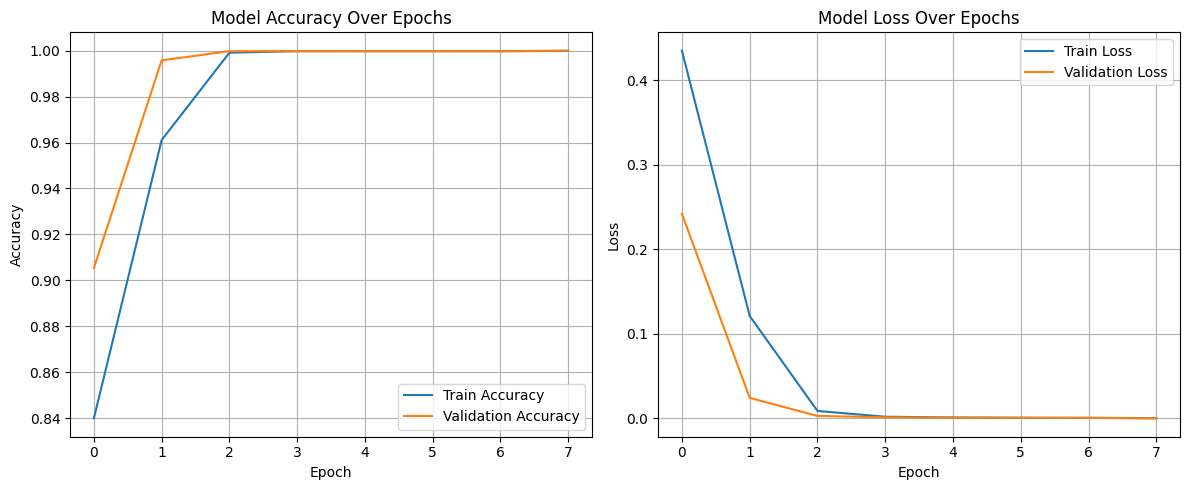

In [435]:
# ------------------------ Model Training and Evaluation ------------------------

# Train the sequence-to-sequence model with attention
history = training_model.fit(
    x=[X_train, decoder_input_train],               # Model inputs: encoder and decoder input sequences
    y=np.expand_dims(Y_train, -1),                  # Targets: one-hot labels (expanded for loss compatibility)
    batch_size=64,                                  # Number of samples per gradient update
    epochs=8,                                       # Total number of training epochs
    validation_data=(
        [X_val, decoder_input_val],                 # Validation inputs
        np.expand_dims(Y_val, -1)                   # Validation targets (expanded as above)
    ),
    verbose=2                                       # Display one line per epoch with progress
)

# ------------------------ Visualization of Training Metrics ------------------------

# Set up the figure with subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [436]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.4f}")

    return score

In [437]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(encoder_model, decoder_model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
round= 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

In [438]:
# ------------------------ Save Model Weights ------------------------
training_model.save_weights("model_weights.weights.h5")

Used weights for a new model and redo the Evaluatrion process

In [439]:
import numpy as np
import tensorflow as tf

# --- Load pre-trained weights into the model ---
training_model.load_weights("model_weights.weights.h5")

# --- Evaluate the model on the validation set using built-in Keras metrics ---
loss, accuracy = training_model.evaluate(
    [X_val, decoder_input_val],
    np.expand_dims(Y_val, -1),  # Expand dimensions to match the expected output shape
    verbose=2
)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    """
    Computes prefix match accuracy between a true and predicted sequence.

    Args:
        y_true (np.array): Ground truth token IDs.
        y_pred (np.array): Predicted token IDs.
        id_to_token (dict): Mapping from token ID to actual token string.
        eos_id (int): End-of-sequence token ID.
        verbose (bool): If True, prints the decoded target and predicted strings.

    Returns:
        float: Proportion of matching tokens in the prefix of prediction vs. target.
    """
    # Decode sequences to strings and remove everything after EOS
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]

    # Tokenize into lists
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()

    # Count matching tokens from the beginning (prefix match)
    match_len = sum(t == p for t, p in zip(t_tokens, p_tokens))
    max_len = max(len(t_tokens), len(p_tokens))

    score = match_len / max_len if max_len > 0 else 0.0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.4f}")

    return score


def evaluate_prefix_accuracy_from_model(
    model, id_to_token, X_val, decoder_input_val, Y_val, num_samples=5000
):
    """
    Evaluates the average prefix accuracy of the model over a number of validation samples.

    Args:
        model (tf.keras.Model): Trained sequence-to-sequence model.
        id_to_token (dict): Mapping from token ID to actual token string.
        X_val (np.array): Encoder input sequences (infix expressions).
        decoder_input_val (np.array): Decoder input sequences (start tokens + shifted output).
        Y_val (np.array): Decoder target sequences (postfix expressions).
        num_samples (int): Number of validation samples to evaluate.

    Returns:
        tuple: Mean and standard deviation of prefix accuracy scores.
    """
    scores = []

    for i in range(num_samples):
        # Prepare single-sample inputs
        encoder_input = np.expand_dims(X_val[i], axis=0)
        decoder_input = np.expand_dims(decoder_input_val[i], axis=0)

        # Make prediction
        prediction = model.predict([encoder_input, decoder_input], verbose=0)
        predicted_ids = np.argmax(prediction[0], axis=-1)

        # Get ground truth
        y_true = Y_val[i]
        y_pred = predicted_ids

        # Compute prefix accuracy for this sample
        score = prefix_accuracy_single(y_true, y_pred, id_to_token)
        scores.append(score)

    return np.mean(scores), np.std(scores)


# --- Run the prefix accuracy evaluation on a subset of the validation set ---
mean_score, std_score = evaluate_prefix_accuracy_from_model(
    training_model, id_to_token, X_val, decoder_input_val, Y_val, num_samples=50
)
print(f"Prefix to Postfix Accuracy: {mean_score:.4f} ± {std_score:.4f}")


32/32 - 0s - 10ms/step - accuracy: 1.0000 - loss: 1.8324e-04
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Prefix to Postfix Accuracy: 1.0000 ± 0.0000


Link: https://drive.google.com/file/d/1OwZQ7maaDxedvDgTyW9gyQKIMV1K0SZ-/view?usp=drive_link

Weights ID: 1OwZQ7maaDxedvDgTyW9gyQKIMV1K0SZ-

Download the weights file from google drive

In [440]:
import gdown
# --- Download weights from Google Drive ---
file_id = "1OwZQ7maaDxedvDgTyW9gyQKIMV1K0SZ-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "gdown_model_weights.weights.h5", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1OwZQ7maaDxedvDgTyW9gyQKIMV1K0SZ-
To: /Users/kasunachinthaperera/Documents/VS Code/Deep Learning/gdown_model_weights.weights.h5
100%|██████████| 2.48M/2.48M [00:02<00:00, 895kB/s] 


'gdown_model_weights.weights.h5'